In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import dependencies

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, SpatialDropout2D
from keras.optimizers import RMSprop
from keras.preprocessing import image 
from keras import backend as K
import os
import numpy as np
from keras.applications.resnet50 import preprocess_input
import PIL.ImageOps    
from keras.utils import np_utils
np.random.seed(23)


Using TensorFlow backend.


# Load the Hanacaraka Dataset


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


X_train original shape: (5100, 60, 78, 1)
X_train shape: (5000, 60, 78, 1)
5000 train samples
1000 test samples


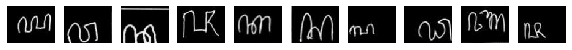

In [4]:
folder = 'gdrive/My Drive/dataset/hanacaraka/'

# Settings
img_rows, img_cols = 60, 78         
nb_classes = 20
number_of_data = 5000

X_train = []
Y_train = []

for cl, fld in enumerate(os.listdir(folder)):
        for f in os.listdir(folder + fld):
                img = image.load_img(folder + fld + '/' + f, grayscale=True, 
                                     target_size=(img_rows, img_cols))
                img = PIL.ImageOps.invert(img)
                img = image.img_to_array(img)
                X_train.append(img.reshape((img_rows, img_cols, 1)))
                Y_train.append(cl)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

shuffled_indices = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffled_indices] 
Y_train = Y_train[shuffled_indices] 
X_test = X_train[X_train.shape[0]//2:]
X_train = X_train[:X_train.shape[0]//2]

Y_test = Y_train[Y_train.shape[0]//2:]
Y_train = Y_train[:Y_train.shape[0]//2]

print('X_train original shape:', X_train.shape)

if K.image_dim_ordering() == 'th':
    # For Theano backend
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    # For TensorFlow backend
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Split train test
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

test_data = 1000

X_train = X_train[:number_of_data]
Y_train = Y_train[:number_of_data]
X_test = X_test[:test_data]
Y_test = Y_test[:test_data]

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
    

# Visualize Hanacaraka dataset
import matplotlib.pyplot as plt
%matplotlib inline

n = 10  
plt.figure(figsize=(10, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(img_rows, img_cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional Neural Network

## Build

In [39]:
# Settings
pool_size = (3, 3)                  # size of pooling area for max pooling
prob_drop_conv = 0.25              # drop probability for dropout @ conv layer
prob_drop_hidden = 0.3              # drop probability for dropout @ fc layer

# Convolutional model
model = Sequential()

# conv1 layer
model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))

# conv2 layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))

# conv2 layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))

# fc input layer
model.add(Flatten())
model.add(Dropout(prob_drop_hidden))

# fc1 layer
model.add(Dense(5120, activation='relu'))
model.add(Dropout(prob_drop_hidden))

# fc2 layer
model.add(Dense(nb_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 60, 78, 8)         80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 39, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 39, 32)        2336      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 20, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 10, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5120)              0         
__________

## Train

In [40]:
# Settings
batch_size = 128
epochs = 10

# Train
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)

Epoch 1/10
5000/5000 [==============================] - 4s 729us/step - loss: 2.2908 - acc: 0.2994
Epoch 2/10
5000/5000 [==============================] - 3s 508us/step - loss: 1.2280 - acc: 0.6174
Epoch 3/10
5000/5000 [==============================] - 3s 508us/step - loss: 0.7884 - acc: 0.7640
Epoch 4/10
5000/5000 [==============================] - 3s 507us/step - loss: 0.4786 - acc: 0.8524
Epoch 5/10
5000/5000 [==============================] - 3s 512us/step - loss: 0.3266 - acc: 0.9002
Epoch 6/10
5000/5000 [==============================] - 3s 513us/step - loss: 0.2232 - acc: 0.9328
Epoch 7/10
5000/5000 [==============================] - 3s 515us/step - loss: 0.1881 - acc: 0.9388
Epoch 8/10
5000/5000 [==============================] - 3s 511us/step - loss: 0.1551 - acc: 0.9560
Epoch 9/10
5000/5000 [==============================] - 3s 515us/step - loss: 0.1240 - acc: 0.9624
Epoch 10/10
5000/5000 [==============================] - 3s 511us/step - loss: 0.0892 - acc: 0.9724


## Evaluate

In [44]:
evaluation = model.evaluate(X_test, Y_test, batch_size=256, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

1000/1000 [==============================] - 0s 116us/step
Summary: Loss over the test dataset: 0.33, Accuracy: 0.90


## Save The model

In [0]:
model.save('hanacaraka_model.h5')